In [ ]:
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix

#I addedthis comment in here

def hillslopediffusion(grid, diffcoeff, fluxes, h0, K, dt):
    # Reload grid infos
    xnum = grid['xnum']
    ynum = grid['ynum']
    dx = grid['dx']
    dy = grid['dy']
    y = grid['y']
    ymax = grid['ymax']
    nodenum = grid['nodenum']
    # Reload fluxes infos
    qxleft = fluxes['l']
    qxright = fluxes['r']
    qytop = fluxes['t']
    qybottom = fluxes['b']
    # Reload diffusivity coefficients
    hmin = diffcoeff['hmin']
    tectonic_uplift = diffcoeff['tectonic_uplift']
    # COMPUTE THE NEW TOPOGRAPHY FIELD
    # Initialize L sparse square matrix and R rhs column vector
    unknowns = nodenum
    R = np.zeros((unknowns,1), dtype=np.float64)
    I = np.zeros((1,unknowns * 5), dtype=np.uint32)  # row coordinates of each coef.
    J = np.zeros((1,unknowns * 5), dtype=np.uint32)  # column coordinates of each coef.
    V = np.zeros((1,unknowns * 5), dtype=np.float64)  # coef.
    # ASSEMBLE R MATRIX AND L VECTOR
    n = -1
    for i in range(xnum):
        for j in range(ynum):
            # Global index
            gi = j + ynum * i
            # Boundary nodes
            # THE TOP ONE HAS TOGRAPHY EQUAL TO THE MINIMUM
            # Top Boundary
            if j == 0:
                n = n + 1
                J[0][n] = gi
                I[0][n] = gi
                V[0][n] = 1.0
                # Dirichlet b.c.
                R[gi] = hmin
            # Left boundary
            elif i == 0:
                n = n + 2
                J[0][n - 1:n+1] = [gi, gi]
                I[0][n - 1:n+1] = [gi, gi + ynum]
                V[0][n - 1:n+1] = [1.0, -1.0]
                # Neumann b.c.
                Kb = (K[i][j] + K[j][i+1]) / 2
                R[gi] = qxleft * dx / Kb
            # Right boundary
            elif i == xnum -1:
                n = n + 2
                J[0][n - 1:n+1] = [gi, gi]
                I[0][n - 1:n+1] = [gi, gi - ynum]
                V[0][n - 1:n+1] = [1.0, -1.0]
                # Neumann b.c.
                Ka = (K[i][j] + K[j][i-1]) / 2
                R[gi] = -qxright * dx / Ka
            # Bottom boundary
            elif j == xnum-1:
                n = n + 2
                J[0][n - 1:n+1] = [gi, gi]
                I[0][n - 1:n+1] = [gi, gi - 1]
                V[0][n - 1:n+1] = [1.0, -1.0]
                # Neumann b.c.
                Kc = (K[j][i] + K[j-1][i]) / 2
                R[gi] = -qybottom * dy / Kc
            # Internal nodes
            else:
                R[gi] = h0[gi] / dt
                # Impose tectonic uplift/subsidence on bottom half of the domain
                if y[j] >= ymax / 2:
                    R[gi] = R[gi] + tectonic_uplift
                Ka = (K[j][i] + K[j][i-1]) / 2
                Kb = (K[j][i] + K[j][i+1]) / 2
                Kc = (K[j][i] + K[j-1][i]) / 2
                Kd = (K[j][i] + K[j+1][i]) / 2
                # Left nodes
                coef1 = -Ka / dx ** 2  # Left node
                coef5 = -Kb / dx ** 2  # Right node
                coef2 = -Kc / dy ** 2  # Top nodes
                coef4 = -Kd / dy ** 2  # Bottom node
                coef3 = 1 / dt - (coef1 + coef2 + coef4 + coef5)  # Central node
                n = n + 5
                J[0][n - 4:n+1] = [gi, gi, gi, gi, gi]
                I[0][n - 4:n+1] = [gi-ynum, gi - 1, gi, gi+1, gi+ynum]
                V[0][n - 4:n+1] = [coef1, coef2, coef3, coef4, coef5]
    # Row Column koefficient
    L = csr_matrix((V[0][:n], (I[0][:n], J[0][:n])), shape=(unknowns, unknowns))
    # Solve
    S = np.linalg.solve(L.toarray(), R)
    return S

In [ ]:
def diffusivity(grid, diffcoeff, h0):
    # Reload grid infos
    xnum = grid['xnum']
    ynum = grid['ynum']
    dx = grid['dx']
    dy = grid['dy']
    x = grid['x']
    y = grid['y']
    nodenum = grid['nodenum']

    # Reload diffusivity coefficients
    K0 = diffcoeff['K0']
    c = diffcoeff['c']
    nn = diffcoeff['nn']
    rainrate = diffcoeff['rainrate']

    # Index lowest neighbour
    IDX_LOW = [0] * nodenum

    # Find lowest neighbour for each node
    for j in range(ynum):
        for i in range(xnum):
            # Global index
            gi = j + ynum * i
            # Set shift indexes
            # i-1    i     i+1
            # + ---- + ---- + j-1
            # |      |      |
            # |      |      |
            # + ---- + ---- + j
            # |      |      |
            # |      |      |
            # + ---- + ---- + j+1
            imin = i - 1
            imax = i + 1
            jmin = j - 1
            jmax = j + 1

            if j == 0:
                jmin = j  # Left boundary nodes
            if j == ynum-1:
                jmax = j  # Right boundary nodes
            if i == 0:
                imin = i  # Top boundary nodes
            if i == xnum-1:
                imax = i  # Bottom boundary nodes

            # Find lowest neighbour
            # Set initial high elevation to find minimum
            hhmin = 1e+30  # Modify here with the DTM min
            for jj in range(jmin, jmax+1):
                for ii in range(imin, imax+1):
                    # Global index
                    ggi = jj + ynum * (ii)
                    if h0[ggi] < hhmin:
                        hhmin = h0[ggi]
                        IDX_LOW[gi] = ggi

            # On the coastline place the node itself as the lowest neighbour
            if j == 0:
                IDX_LOW[gi] = gi

    # Assign uniform Q = rainrate * surface area of the cell
    Area = dx * dy  # cell area
    q = np.ones((nodenum)) * rainrate * Area # m^3/s

    # Distribute water to the lowest neighbour
    # Sort array from highest to lowest topography
    Idx = sorted(range(len(h0)), key=lambda k: h0[k], reverse=True)

    for i in range(nodenum):
        # ASSIGN THE RAINFALL
        # Find point with highest elevation
        idx_hmax = Idx[i]

        # Load lowest neighbour index
        idx_hlow = IDX_LOW[idx_hmax]

        # Redistribute water to the lowest neighbour, only if not same node
        if idx_hlow != idx_hmax:
            # Add water to the lowest neighbour node
            # Keep water on the highest node
            # For the highest points, this amount of water is equal to
            # rainrate * Area only because no other node can add to it water.
            # For other nodes, the amount of water is the one coming
            # from rain in that area + the one collected upstream in the
            # hydrographic basin
            q[idx_hlow] += q[idx_hmax]

    # Compute hillslope diffusivity
    K = [[0] * xnum for _ in range(ynum)]

    for i in range(xnum):
        for j in range(ynum):
            # Global index
            gi = j + ynum * i

            # Hillslope diffusivity
            # For j==1, K = 0, because h = 0 for all of them
            if i > 0:
                K[j][i] = K0 + c * q[gi] ** nn

            # Scale diffusivity by local hillslope for internal nodes only
            if i > 0 and i < xnum-1 and j > 0 and j < ynum-1:
                pass  # K[j - 1][i - 1] = K[j - 1][i - 1] * Slope_local[j - 1][i - 1] / Slope_regional

    plt.figure(2)
    q2d = np.reshape(q, (ynum, xnum), order='F')
    plt.subplot(211)
    plt.pcolor(x/1e+3, y/1e+3, q2d)
    plt.colorbar()
    plt.axis('image')
    plt.xlabel(' X (km)')
    plt.ylabel(' Y (km)')
    plt.title('Fluvial discharge (m^3/s)')
    plt.subplot(212)
    plt.pcolor(x/1e+3, y/1e+3, np.log10(K))
    plt.colorbar()
    plt.axis('image')
    plt.xlabel(' X (km)')
    plt.ylabel(' Y (km)')
    plt.title('log10(Diffusivity) (m^2/s)')

    plt.show()
    return K

Timestep = 100.0 years


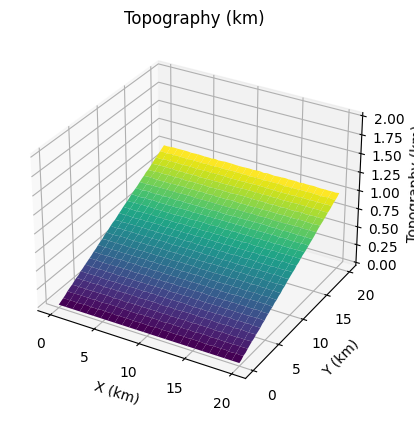

Start cycle 0 , Timestep = 0.1 kyr


<ipython-input-2-43beb5a334b0>:117: RuntimeWarning: divide by zero encountered in log10
  plt.pcolor(x/1e+3, y/1e+3, np.log10(K))


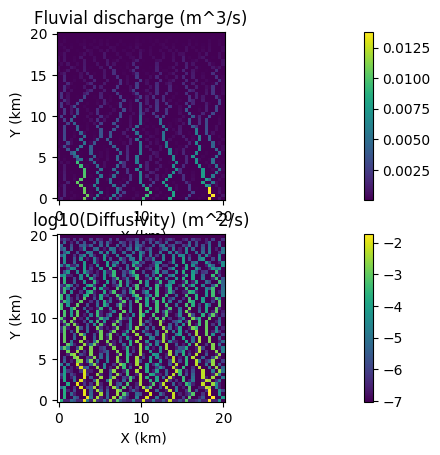

Time for computing mass diffusivity = 0.6313045024871826
Time for solving hillslope diffusion eq. = 0.6041538715362549


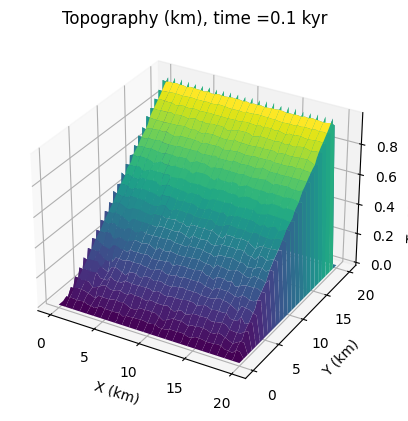

End cycle 0 , Time = 0.1 kyr

Start cycle 1 , Timestep = 0.1 kyr


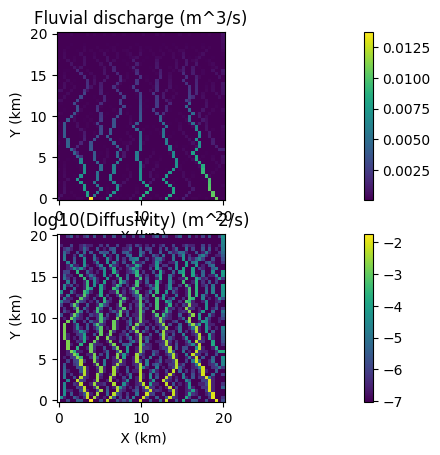

Time for computing mass diffusivity = 0.6400876045227051
Time for solving hillslope diffusion eq. = 0.5833160877227783


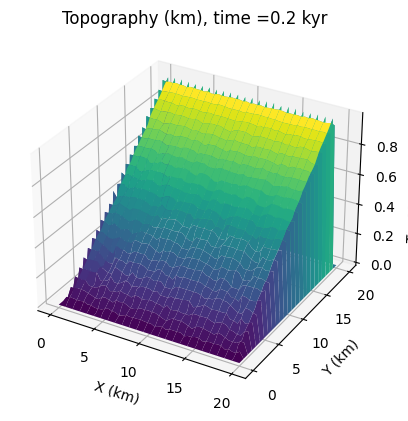

End cycle 1 , Time = 0.2 kyr

Start cycle 2 , Timestep = 0.1 kyr


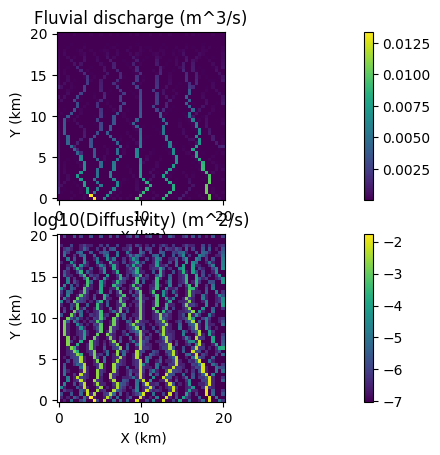

Time for computing mass diffusivity = 0.5955705642700195
Time for solving hillslope diffusion eq. = 0.6000795364379883


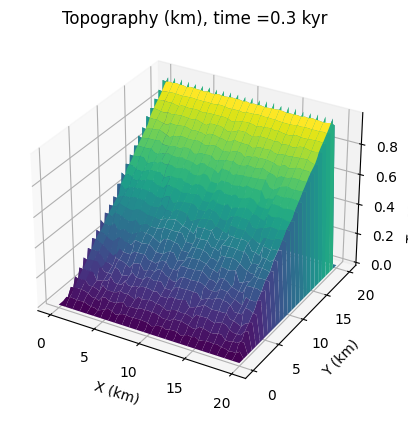

End cycle 2 , Time = 0.3 kyr

Start cycle 3 , Timestep = 0.1 kyr


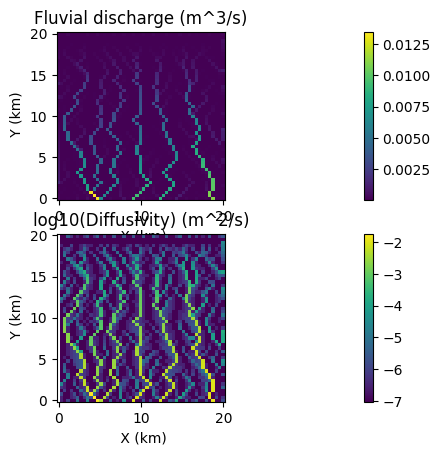

Time for computing mass diffusivity = 1.1769812107086182
Time for solving hillslope diffusion eq. = 1.1091060638427734


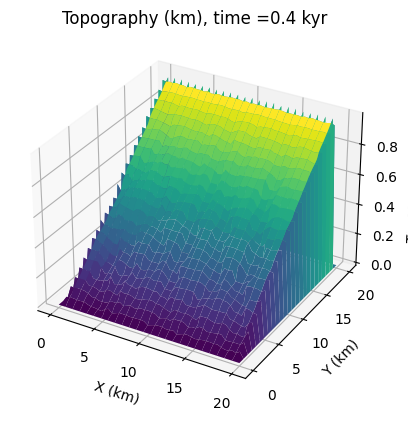

End cycle 3 , Time = 0.4 kyr

Start cycle 4 , Timestep = 0.1 kyr


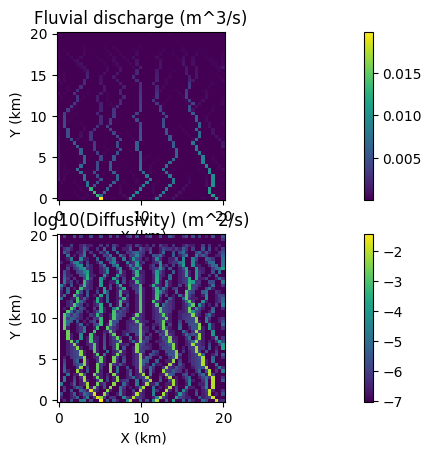

Time for computing mass diffusivity = 1.1299147605895996
Time for solving hillslope diffusion eq. = 1.6056392192840576


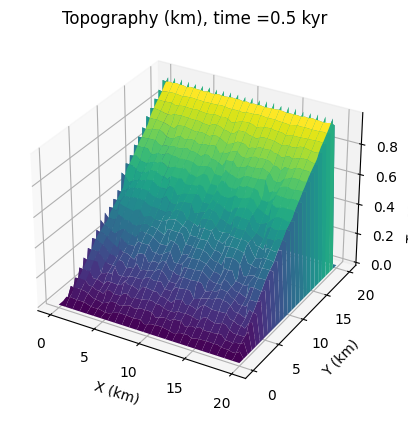

End cycle 4 , Time = 0.5 kyr

Start cycle 5 , Timestep = 0.1 kyr


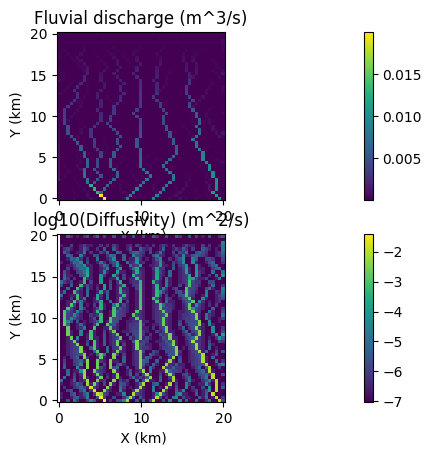

Time for computing mass diffusivity = 1.6484851837158203
Time for solving hillslope diffusion eq. = 1.4589793682098389


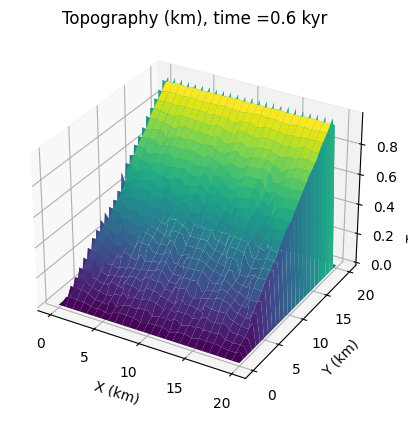

End cycle 5 , Time = 0.6 kyr

Start cycle 6 , Timestep = 0.1 kyr


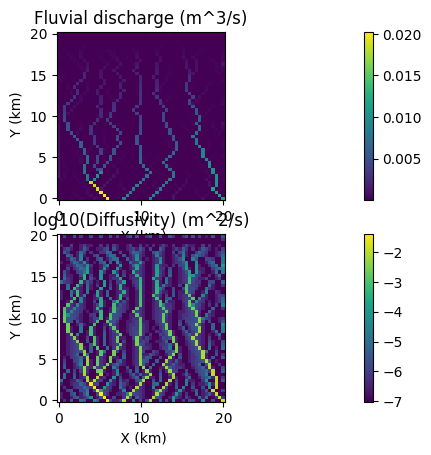

Time for computing mass diffusivity = 1.3302485942840576
Time for solving hillslope diffusion eq. = 1.2800495624542236


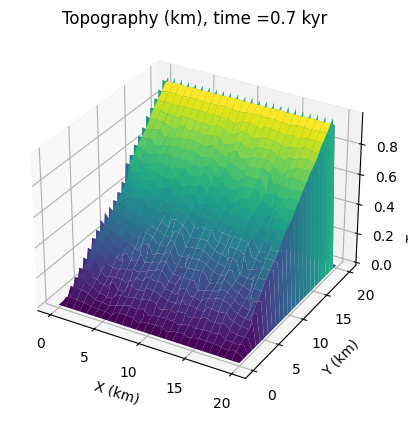

End cycle 6 , Time = 0.7 kyr

Start cycle 7 , Timestep = 0.1 kyr


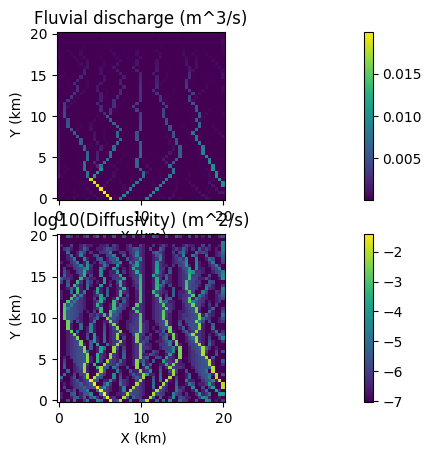

Time for computing mass diffusivity = 1.1689457893371582
Time for solving hillslope diffusion eq. = 1.2926721572875977


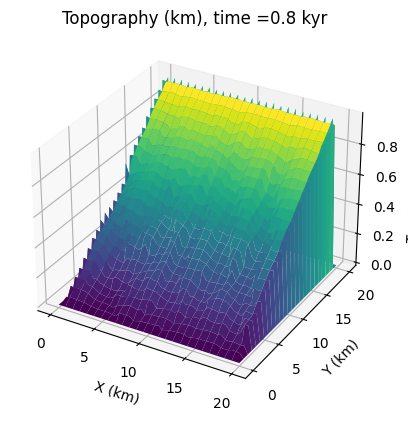

End cycle 7 , Time = 0.8 kyr

Start cycle 8 , Timestep = 0.1 kyr


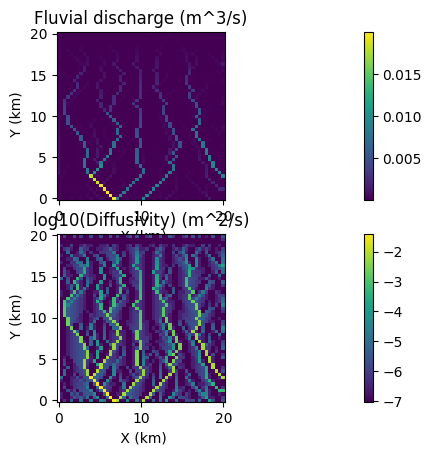

Time for computing mass diffusivity = 2.7261691093444824
Time for solving hillslope diffusion eq. = 1.010802984237671


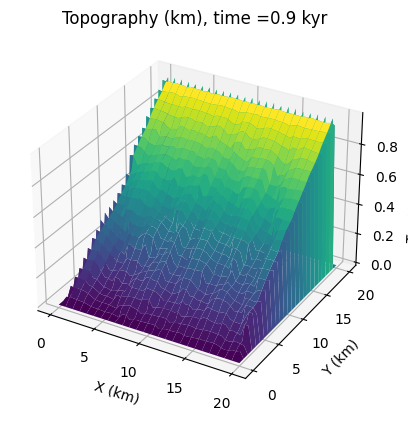

End cycle 8 , Time = 0.9 kyr

Start cycle 9 , Timestep = 0.1 kyr


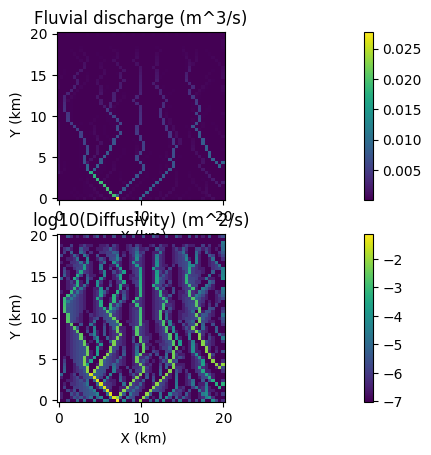

Time for computing mass diffusivity = 1.0828628540039062
Time for solving hillslope diffusion eq. = 0.6252467632293701


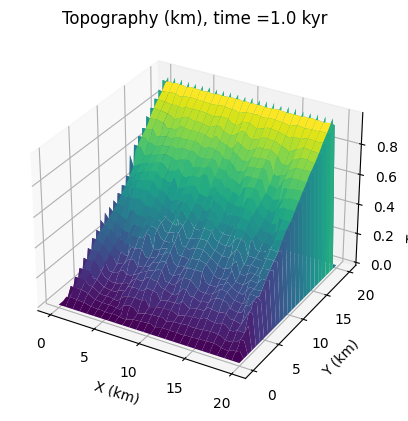

End cycle 9 , Time = 1.0 kyr



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# 1) Discretize domain, make 2D grid
vertical_exaggeration = 1
xnum = 51  # Here the dtm's nodes
xmax = 20e+3  # [m]
dx = xmax / (xnum - 1)  # [m]
x = np.linspace(0, xmax, xnum)  # [m]
ynum = 51  # Here the dtm's nodes
ymax = 20e+3  # [m]
dy = ymax / (ynum - 1)  # [m]
y = np.linspace(0, ymax, ynum)  # [m]
nodenum = xnum * ynum
# Make grid structure
grid = {
    'xnum': xnum,
    'ynum': ynum,
    'dx': dx,
    'dy': dy,
    'x': x,
    'y': y,
    'xmax': xmax,
    'ymax': ymax,
    'nodenum': nodenum
}

# 2) Define input variables fields
# Diffusivity: K = K0 + c*Q^nn [m^2/s]
K0 = 3.2e-8  # [m^2/s]
c = 100  # [s^(n-1)/m^(3n-2)]
nn = 2
rainrate = 0.005  # [m/yr]
tectonic_uplift = 0.000  # [m/yr]
# Convert to m/s
sec2year = 365.25 * 86400  # [s]
rainrate = rainrate / sec2year  # [m/s]
tectonic_uplift = tectonic_uplift / sec2year  # [m/s]
# Define initial topography h0
# HERE SET THE DTM'S Z
noise_max = 10  # [m], maximum noise
hmax = 1e+3  # [m]
hmin = 0  # [m]
Slope_regional = (hmax - hmin) / ymax
h0 = np.zeros(nodenum)  # [m]
for i in range(xnum):
    for j in range(ynum):
        gi = j + ynum * (i)
        # Set coastline to water level
        if j == 0:
            h0[gi] = hmin
        else:
            h0[gi] = hmin + Slope_regional * y[j] + (np.random.rand() - 0.5) * noise_max

# Make diffusivity coefficients structure
diffcoeff = {
    'K0': K0,
    'c': c,
    'nn': nn,
    'rainrate': rainrate,
    'Slope_regional': Slope_regional,
    'hmin': hmin,
    'hmax': hmax,
    'tectonic_uplift': tectonic_uplift,
    'sec2year': sec2year
}

# Define timestep, timemax and # cycles
years = 100  # [yr]
dt = years * sec2year  # [s]
print('Timestep =', dt / sec2year, 'years')
mytime = 0  # [s]
timemax = dt * 10  # [s]
cyclemax = int(timemax / dt)

# Define fluxes at the boundaries
qxleft = 0.000  # [m^2/s]
qxright = 0.000  # [m^2/s]
qytop = 0.000  # [m^2/s]
qybottom = 0.000  # [m^2/s]
# Make fluxes structure
fluxes = {
    'l': qxleft,
    'r': qxright,
    't': qytop,
    'b': qybottom
}

# Plot initial setup
h02d = np.reshape(h0, (ynum, xnum), order='F')
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(x / 1000, y / 1000)
ax.plot_surface(X, Y, h02d / 1000, cmap='viridis')
ax.set_zlim([0, hmax / 1e+3 * 2])
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Topography (km)')
ax.set_title('Topography (km)')
plt.show()

for cycle in range(cyclemax):
    print('Start cycle', cycle, ', Timestep =', dt / sec2year / 1000, 'kyr')
    # Compute hillslope diffusivity
    tic = time.time()
    # Index lowest neighbour
    K = diffusivity(grid, diffcoeff, h0)
    print('Time for computing mass diffusivity =', time.time() - tic)
    # 3) Compute new topography field
    tic = time.time()
    h = hillslopediffusion(grid, diffcoeff, fluxes, h0, K, dt)
    print('Time for solving hillslope diffusion eq. =', time.time() - tic)
    # Map new SURFACE from column vector h to 2D matrix h2d
    h2d = np.reshape(h, (ynum, xnum), order='F')
    # Advance time
    mytime = mytime + dt
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, h2d / 1000 * vertical_exaggeration, cmap='viridis')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Topography (km)')
    ax.set_title('Topography (km), time =' + str(mytime / sec2year / 1000) + ' kyr')
    plt.show()
    # Set old topography for next cycle
    h0 = h
    print('End cycle', cycle, ', Time =', mytime / sec2year / 1000, 'kyr')
    print()

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)